In [ ]:
import os
print(os.path.abspath(os.curdir))
os.chdir("..")
print(os.path.abspath(os.curdir))
from embeddings import BERT_WordEmbeddings_L6, BERT_WordEmbeddings_L7, GloVe, FastTextEmbeddings, Word2VecEmbeddings, GraniteMultilingualEmbeddings
from embeddings import BERT_Encoder_L6, BERT_Encoder_L7
from embeddings import SBERT_Encoder
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from utils import *

/Users/greencode/Documents/Code/MCTB/testing
/Users/greencode/Documents/Code/MCTB


/opt/homebrew/anaconda3/envs/MCTB/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
from pathlib import Path
import numpy as np
import pandas as pd

JSON_PATH = Path("data/correlation_models_brick_300prompts.json")  # change if needed
TEMPERATURE_KEY = '{"temperature": 0.5}'  # the key present in your file
RESCALE_TO_TARGET_RANGE = False            # set True to rescale 10–50 -> 1–5

def to_float(x):
    """Convert a single string like '12' or '12\n' to float safely."""
    if isinstance(x, (int, float)):
        return float(x)
    return float(str(x).strip())

def avg_pred(pred_triplet):
    """Each item is like ['12']; take the first element and average across the 3 runs."""
    return np.mean([to_float(p[0]) for p in pred_triplet])

def rescale_10_50_to_1_5(values):
    """
    Linearly map 10..50 -> 1..5.
    This is optional and does NOT affect Pearson correlations,
    but shown for completeness.
    """
    src_min, src_max = 10.0, 50.0
    dst_min, dst_max = 1.0, 5.0
    scale = (dst_max - dst_min) / (src_max - src_min)  # 4 / 40 = 0.1
    return dst_min + (values - src_min) * scale


In [3]:
with JSON_PATH.open() as f:
    data = json.load(f)

models = sorted({k for entry in data for k in entry.keys() if k != "config"})

rows = []
for entry in data:
    target = float(entry["config"]["target"])
    row = {"target": target}
    for m in models:
        preds = entry[m][TEMPERATURE_KEY] 
        row[m] = avg_pred(preds)
    rows.append(row)

df = pd.DataFrame(rows)

if RESCALE_TO_TARGET_RANGE:
    for m in models:
        df[m] = rescale_10_50_to_1_5(df[m])

correlations = {
    m: float(np.corrcoef(df["target"], df[m])[0, 1]) for m in models
}

correlations_sorted = dict(sorted(correlations.items(), key=lambda kv: kv[1], reverse=True))
best_model = max(correlations, key=correlations.get)

print("Correlations (higher is better):")
for m, r in correlations_sorted.items():
    print(f"  {m:30s}  r = {r: .3f}")

print(f"\nBest model: {best_model} (r = {correlations[best_model]:.3f})")

Correlations (higher is better):
  gemini/gemini-2.5-flash         r =  0.561
  gemini/gemini-2.5-pro           r =  0.560
  gemini/gemini-2.0-flash         r =  0.552
  gemini/gemini-2.5-flash-lite    r =  0.509
  ollama/gemma3n:e4b              r =  0.192

Best model: gemini/gemini-2.5-flash (r = 0.561)


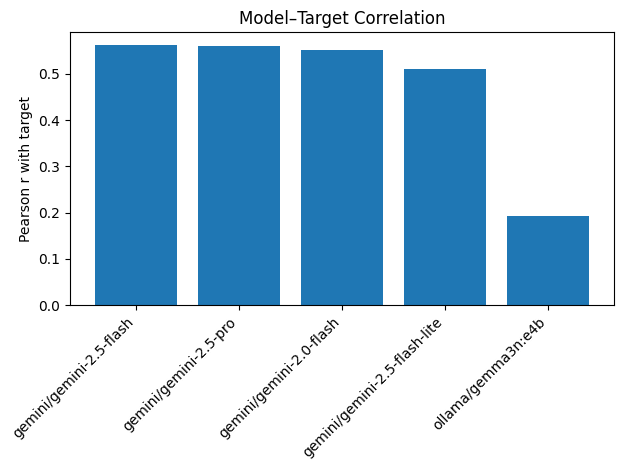

In [ ]:
plt.figure()
plt.bar(correlations_sorted.keys(), correlations_sorted.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pearson r with target")
plt.title("Model-Target Correlation")
plt.tight_layout()
plt.show()